In [92]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pysd
import pandas as pd
import scipy as sp

random.seed(111)
np.random.seed(111)

plt.rcParams['text.usetex'] = True
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["figure.dpi"] = 300

# A Collection of Non-Linear Stock and Flow Models

### Modeling the Biological Mechanisms That Determine the Dynamics of the Stress Response of the Human Body

Gizem Aktaş and Yaman Barlas 2018

I was able to simulate this model and perturb it with stochastic input, but since it was never published, it isn't well documented.

#### Stock and Flow  Graphic

![](https://metasd.com/wp-content/uploads/2018/09/stress_diag-1024x467.png)

Poster abstract [here.](https://proceedings.systemdynamics.org/2018/proceed/papers/P2360.pdf)

Download available [here](https://metasd.com/2018/09/biological-dynamics-stress-response/).

In [2]:
# Read in the model
stress_model = pysd.read_vensim("../../Data/StressResponseModel/StressResponseModel_converted 8.mdl")
# Run the simulation
X = stress_model.run(params={"External Stress": 1}, final_time=10)
X.describe()

,INITIAL TIME,FINAL TIME,TIME STEP,SAVEPER,Avg Cytokine Input,Cytokine Input,Cytokine Input Averaging,Cytokine Input Avg Time,Cytokine Pulse Duration,Cytokine Pulse End,...,Serotonin Eff on Responsiveness,Ref Cort Responsiveness to Ser,Ref RelTime Responsiveness to Ser,Ser Response to Ser,Ser Responsiveness to Ser,Ref Ser Responsiveness to Ser,Ser Eff on Ser,"""DR Curve for Serotonin-Serotonin""","""DR Curve for Ser-Cortisol""","""DR Curve for Ser-RelTime"""
count,321.0,321.0,321.00000,321.00000,321.0,321.0,321.0,321.0,321.00000,321.0,...,321.000000,3.210000e+02,321.0,321.000000,321.000000,321.0,321.000000,321.000000,321.000000,321.000000
mean,0.0,10.0,0.03125,0.03125,0.0,0.0,0.0,24.0,0.03125,30.0,...,0.979837,8.000000e-01,5.0,0.738192,1.989427,2.0,1.251235,0.370861,0.662510,0.960889
std,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.008433,2.223913e-16,0.0,0.109610,0.007990,0.0,0.102335,0.053649,0.108834,0.021233
min,0.0,10.0,0.03125,0.03125,0.0,0.0,0.0,24.0,0.03125,30.0,...,0.972234,8.000000e-01,5.0,0.627725,1.975208,2.0,1.000000,0.317802,0.375000,0.900000
25%,0.0,10.0,0.03125,0.03125,0.0,0.0,0.0,24.0,0.03125,30.0,...,0.972701,8.000000e-01,5.0,0.638573,1.982282,2.0,1.178428,0.322140,0.646241,0.962240
50%,0.0,10.0,0.03125,0.03125,0.0,0.0,0.0,24.0,0.03125,30.0,...,0.976458,8.000000e-01,5.0,0.683525,1.990226,2.0,1.306701,0.343441,0.700808,0.968089
75%,0.0,10.0,0.03125,0.03125,0.0,0.0,0.0,24.0,0.03125,30.0,...,0.983554,8.000000e-01,5.0,0.818915,1.997011,2.0,1.343709,0.410012,0.742001,0.974737
max,0.0,10.0,0.03125,0.03125,0.0,0.0,0.0,24.0,0.03125,30.0,...,1.000000,8.000000e-01,5.0,1.000000,2.000000,2.0,1.348541,0.500000,0.757483,0.977236


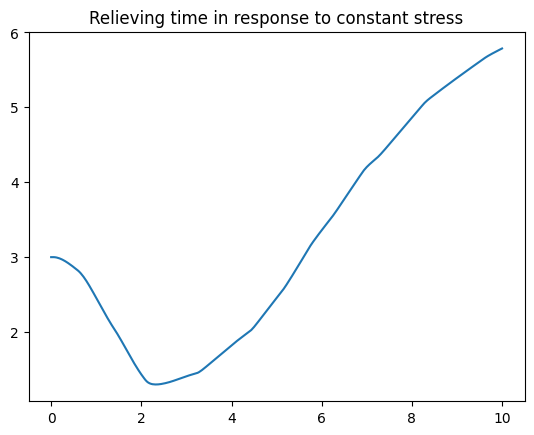

In [3]:
plt.plot(X["Relieving Time"])
plt.title("Relieving time in response to constant stress")
plt.show()

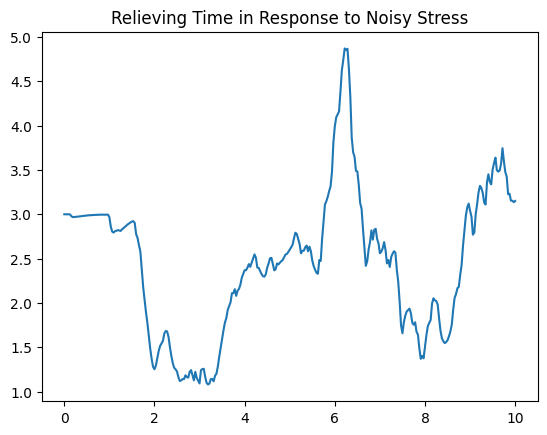

In [4]:
noisy_extern_stress = lambda : 1 + 10 * np.random.randn()

stress_model.components.external_stress = noisy_extern_stress
X = stress_model.run(final_time=10)
plt.plot(X["Relieving Time"])
plt.title("Relieving Time in Response to Noisy Stress")
plt.show()

### Financial Instability

Available [here](https://exchange.iseesystems.com/models/player/crelis/financial-instability).

In [5]:
financial_model = pysd.read_xmile("../../Data/FinancialInstabilityModel/Financial-instability.stmx")

/Users/djpassey/Code/graphinference/graphinf_venv/lib/python3.9/site-packages/pysd/builders/python/python_expressions_builder.py:462: UserWarning: 

Trying to translate 'HISTORY' which it is not implemented on PySD. The translated model will crash... 
  warnings.warn(


Because `pysd` does not implement a `HISTORY` operation, it can't simulate time delays. By looking into the .stmx file, and generated python model, I was able to implement the delay component of economic growth rate as follows.

In [6]:

class EconomicGrowthRate:
    """Economic growth rate in the finanial instability model.

    Stores historical production values in order to implement
    a delay. Pysd does not implement Stella's HISTROY function.
    """
    def __init__(self):
        self.time = []
        self.production_history = []
        self.delay = 1.0

    def __call__(self):

        # Check if the simulation was restarted
        current_time = financial_model.components.time()
        initial_time = financial_model.components.initial_time()
        time_step = financial_model.components.time_step()
        if (current_time - initial_time) < time_step:
            # Reset history if the simulation was restarted
            self.time = []
            self.production_history = []

        # Retrieve and store current time and economic production
        self.time.append(current_time)
        curr_production = financial_model.components.production()
        self.production_history.append(curr_production)

        # In the case that there is not enough history return zero
        if current_time < self.delay:
            return 0.0

        # Interpolate past production
        prev_production_func = sp.interpolate.interp1d(
            self.time,
            self.production_history
        )
        # Retrieve past production
        prev_production = prev_production_func(current_time - self.delay)
        # Return (p[t] - p[t-1]) / p[t-1] where p is production.
        return financial_model.components.zidz(curr_production - prev_production, prev_production)


        

In [7]:
# Assign this new growth rate function to the model.
financial_model.components.economic_growth_rate = EconomicGrowthRate()

# Simulate
econ_indicators = ["capital", "economic growth rate", "employment rate", "profits", "wage share"]
X = financial_model.run(
    final_time=800,
    return_columns=econ_indicators,
    initial_condition=(0, {"capital": 200})
)


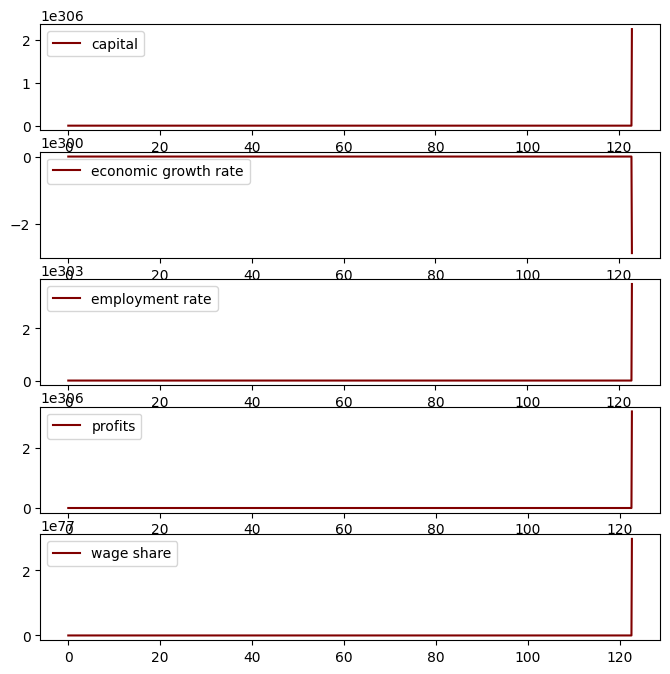

In [8]:

fig, ax = plt.subplots(5, 1, figsize=(8,8))
for i, ei in enumerate(econ_indicators):
    ax[i].plot(X[ei], label=ei, color="maroon")
    ax[i].legend()


plt.show()

#### Helpful Links

[Opiod use model](https://jamanetwork.com/journals/jamanetworkopen/fullarticle/2723405)

[MetaSD Model library](https://metasd.com/model-library/)

### Limits to Growth

This is the idea that inherent limits appear in every situation, that no growth can continue unabated. 

Some examples: population running into resouce constraints.

A rabbit population grows, the more of them there are, the more children they have.

The rate of change in population is described by a constant factor times the current population.

$$ \frac{dr}{dt} = ar $$

The ability of the environment to supply food is fixed. Too many rabbits and some of the rabbits will starve.

$$ \frac{dr}{dt} = ar - b \, \text{max}(r - c, 0) $$

`rabbits / time = (1 / time) * rabbits - (1 / time) rabbits`

We can look at units to explore.

What is the death rate. Rabbits die at a faster rate the higher they are above the carrying capacity.



Where $c$ is the carrying capacity.

The logistic equation is
$$ \frac{dp}{dt} = rp(1 - \frac{p}{K})$$

In this equation, when $0 < p < K$, then $0 < \frac{p}{K} < 1$ and therefore, $(1 - \frac{p}{K}) > 0$ This increases the growth rate. The closer that $p$ gets to $K$, the smaller the rate of growth becomes, until, when $p > K$, the rate changes to negaitve, however, this never occurs. If the initial condition is above the carrying capacity it will regress down to the carrying capacity



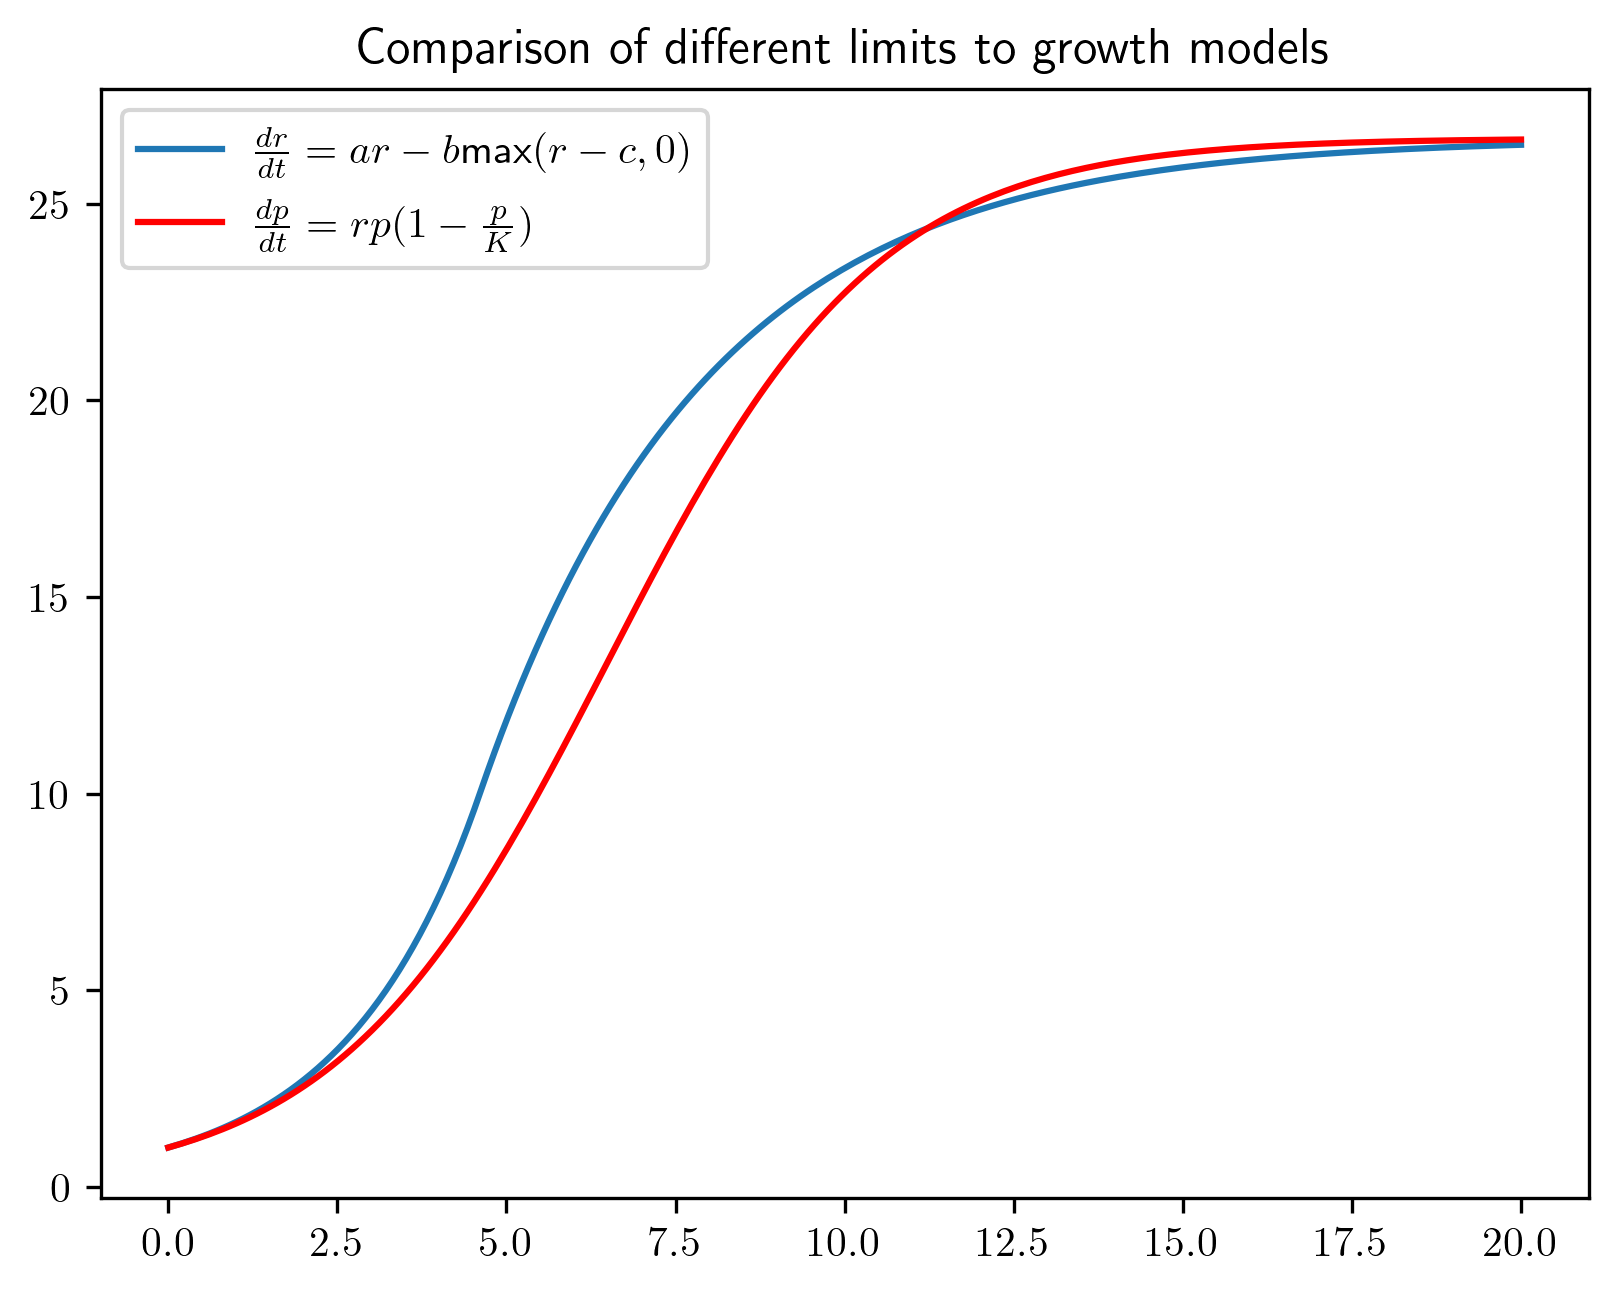

In [107]:
def rabbit_deriv(y, t, a, b, c):
    return a * y - b * max(y - c, 0)

def logistic_deriv(y, t, r, K):
    return r * y * (1 - y / K)

T = 20
t = np.linspace(0, T, T * 10)
a = 0.5
b = 0.8
c = 10
ps = (a, b, c)
y0 = 1
K = b * c / (b - a)

R = sp.integrate.odeint(rabbit_deriv, y0, t, ps)
P = sp.integrate.odeint(logistic_deriv, y0, t, (a, K))
plt.plot(t, R, label=r"$\frac{dr}{dt} = ar - b$max$(r - c, 0)$")
plt.plot(t, P, c="r", label=r"$\frac{dp}{dt} = rp(1 - \frac{p}{K})$")
plt.legend()
plt.title("Comparison of different limits to growth models")
plt.show()

### Carrying capacity of the model using the max function

The two models we used before leveraged a non-linear mechanism to slow the rate of growth down to zero as the state of the model approached a certain value.

In the case of the first model, 
$$\frac{dr}{dt} = ar - b\,\text{max}(r - c, 0)$$
we see that equilibrium occurs when
$$ar - b\,\text{max}(r - c, 0) = 0$$

Let's begin by assuming $r(0)$, $a$, $b$ and $c$ are all positive.

When $r \leq c$, the equation reduces to exponential growth. When $r > c$,
the equation becomes 
$$\frac{dr}{dt} = ar - b(r - c) = (a-b)r + bc$$
Then, the state stops growing when
$$0 = (a-b)r + bc$$
$$ bc = (b-a)r$$
$$ r = \frac{bc}{b-a}$$
$$ \frac{c}{1-\frac{a}{b}} = r$$
This is the carrying capacity. Note that this is only positive when $a < b$. If $a > b$, this value is
negative and therefore, the growth will never slow. 

When $a = b$, the model begins with exponetial growth, but once $r(t) \geq c$,
then $\frac{dr}{dt} = bc$ and the growth is linear.

### Incoorperating a decay

The next question is how we can incooperate a decay following the point where the limit is reached.
The idea behind this is that in some systems, growth happens so quickly, that it leaves you without the ability to support yourself and when the limit is reached, a period of decay follows.

Let's incorperate expectations into this. Let's say I am a business that is growing. I continue to hire in anticipation of future growth. However, I run into a limit that I did not forsee, and now I have too many employees and I can't pay them so I have to fire some.

We'll try to model this a couple different ways.

1. Hiring happens when we anticipate revenue growth and when we have enough money
2. Revenue grows as we hire more people, but at a certain point it stops. New hires cost money.

Two variable model, $R$, revenue and $E$ employees. We will model revenue as
$$\frac{dR}{dt} = rE(1 - \frac{E}{E^*})$$

Where $E^*$ represents the number of employees where revenue growth is zero, because supply meets demand.

If we model hiring as increasing when revenue is higher than wages paid to employees, then the company will stop hiring as revenue slows. However, this slowdown may not overshoot the optimal number of employees.

$$
\frac{dE}{dt} = R - wE
$$

Let's see what happens.

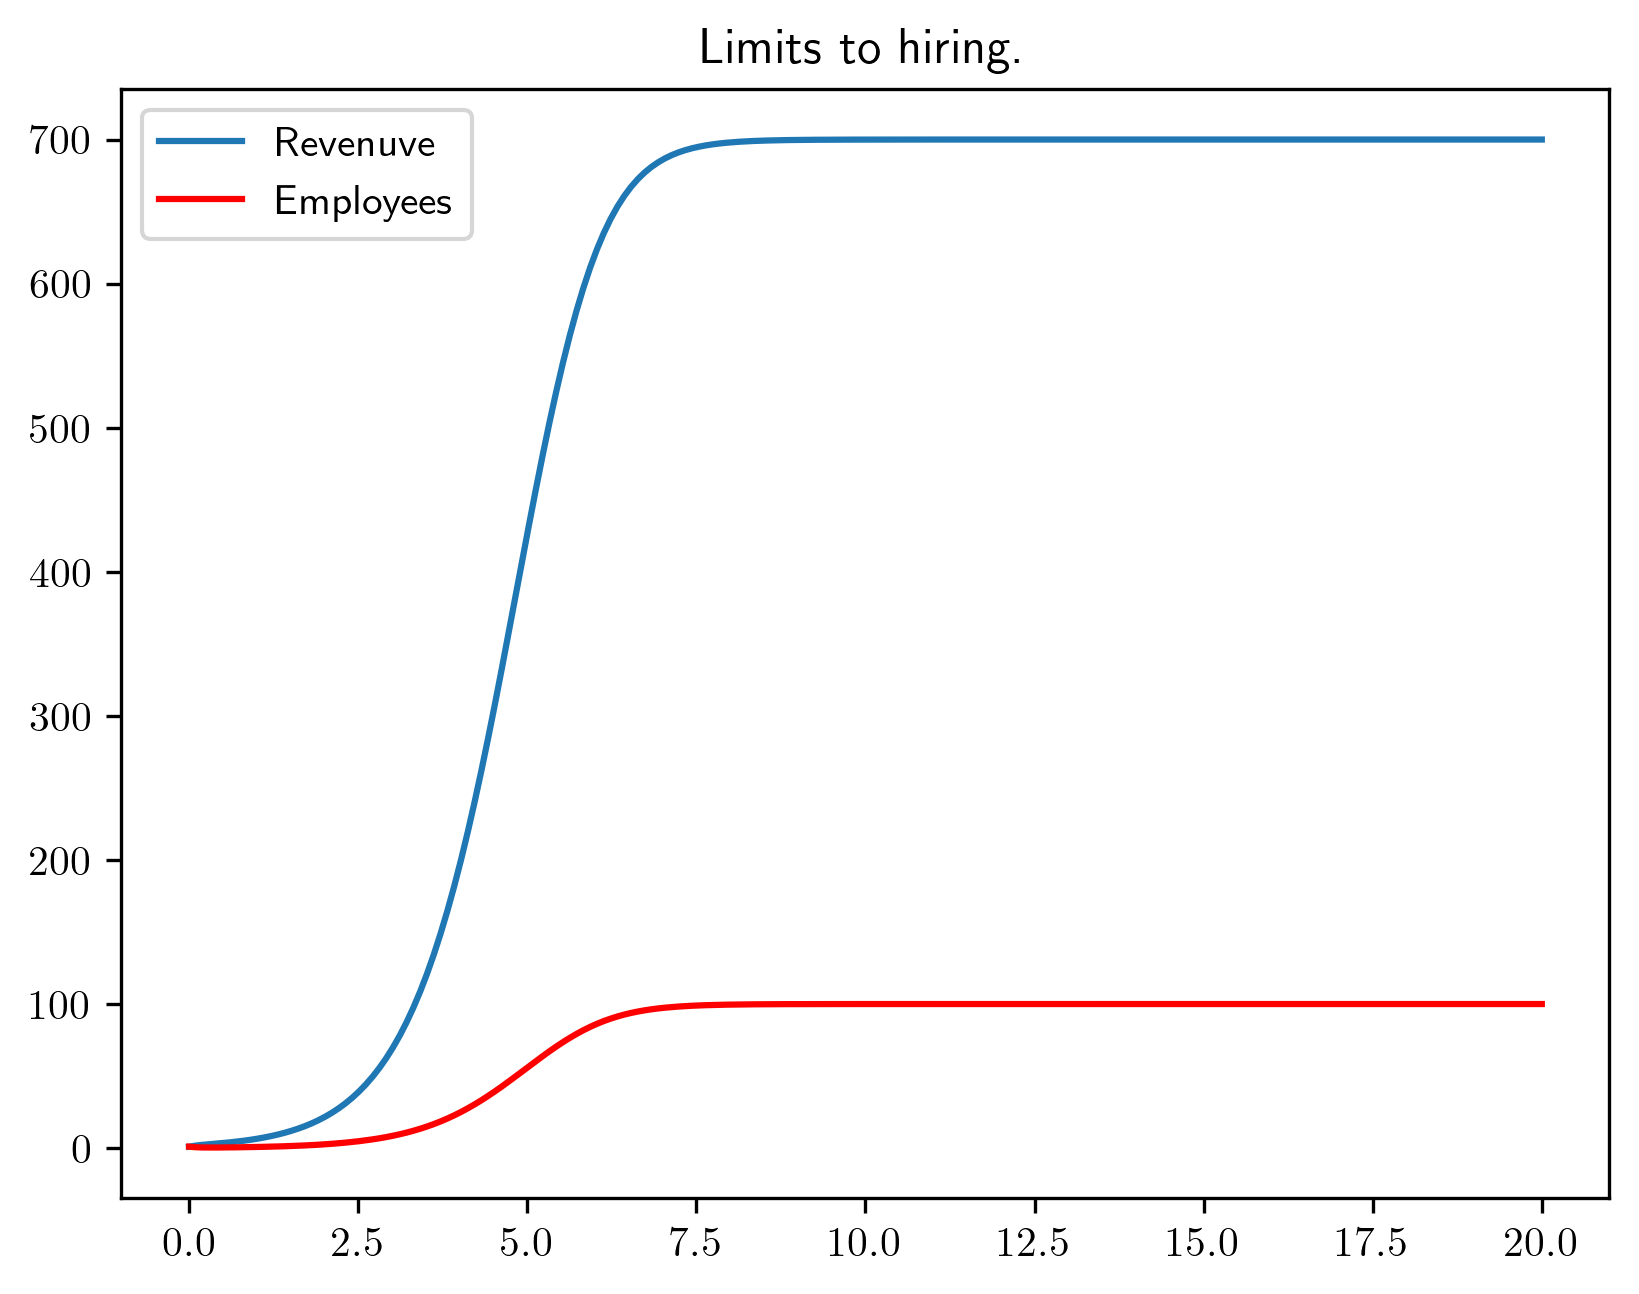

In [111]:
def limits_to_hiring_deriv(y, t, r, Estar, w):
    R, E = y
    return [r * E * (1 - E/Estar), R - w*E]

T = 20
t = np.linspace(0, T, T * 10)
r = 10
Estar = 100
w = 7
ps = (r, Estar, w)
y0 = [1, 1]

X = sp.integrate.odeint(limits_to_hiring_deriv, y0, t, ps)
plt.plot(t, X[:, 0], label="Revenuve")
plt.plot(t, X[:, 1], c="r", label="Employees")
plt.legend()
plt.title("Limits to Hiring")
plt.show()

We can see that this model did not capture an overshoot. Let's revise it. Let's say that instead of hiring based on current revenue, they hire based on expected revenue, and they do not anticipate the slowdown.

We might say that they expect exponentual revenue growth, that is, $\R = e^{rt}$, but if they always expect exponential growth, they will always hire and never stop. Then, we can incoorperate a third variable, expected revenue: $\hat{R}$. Expected revenue growth is exponential, but tries to follow the true revenue.

$$ \frac{d\hat{R}}{dt} = rE + a(R - \hat{R})$$

Here, $a$ denotes attention paid to true revenue minus expected.

Now we will base hiring on expected revenue instead of true revenue. This produces:

$$
\frac{dR}{dt} = rE(1 - \frac{E}{E^*})
$$

$$
\frac{dE}{dt} = \hat{R} - wE
$$

$$
\frac{d\hat{R}}{dt} = rE + a(R - \hat{R})
$$

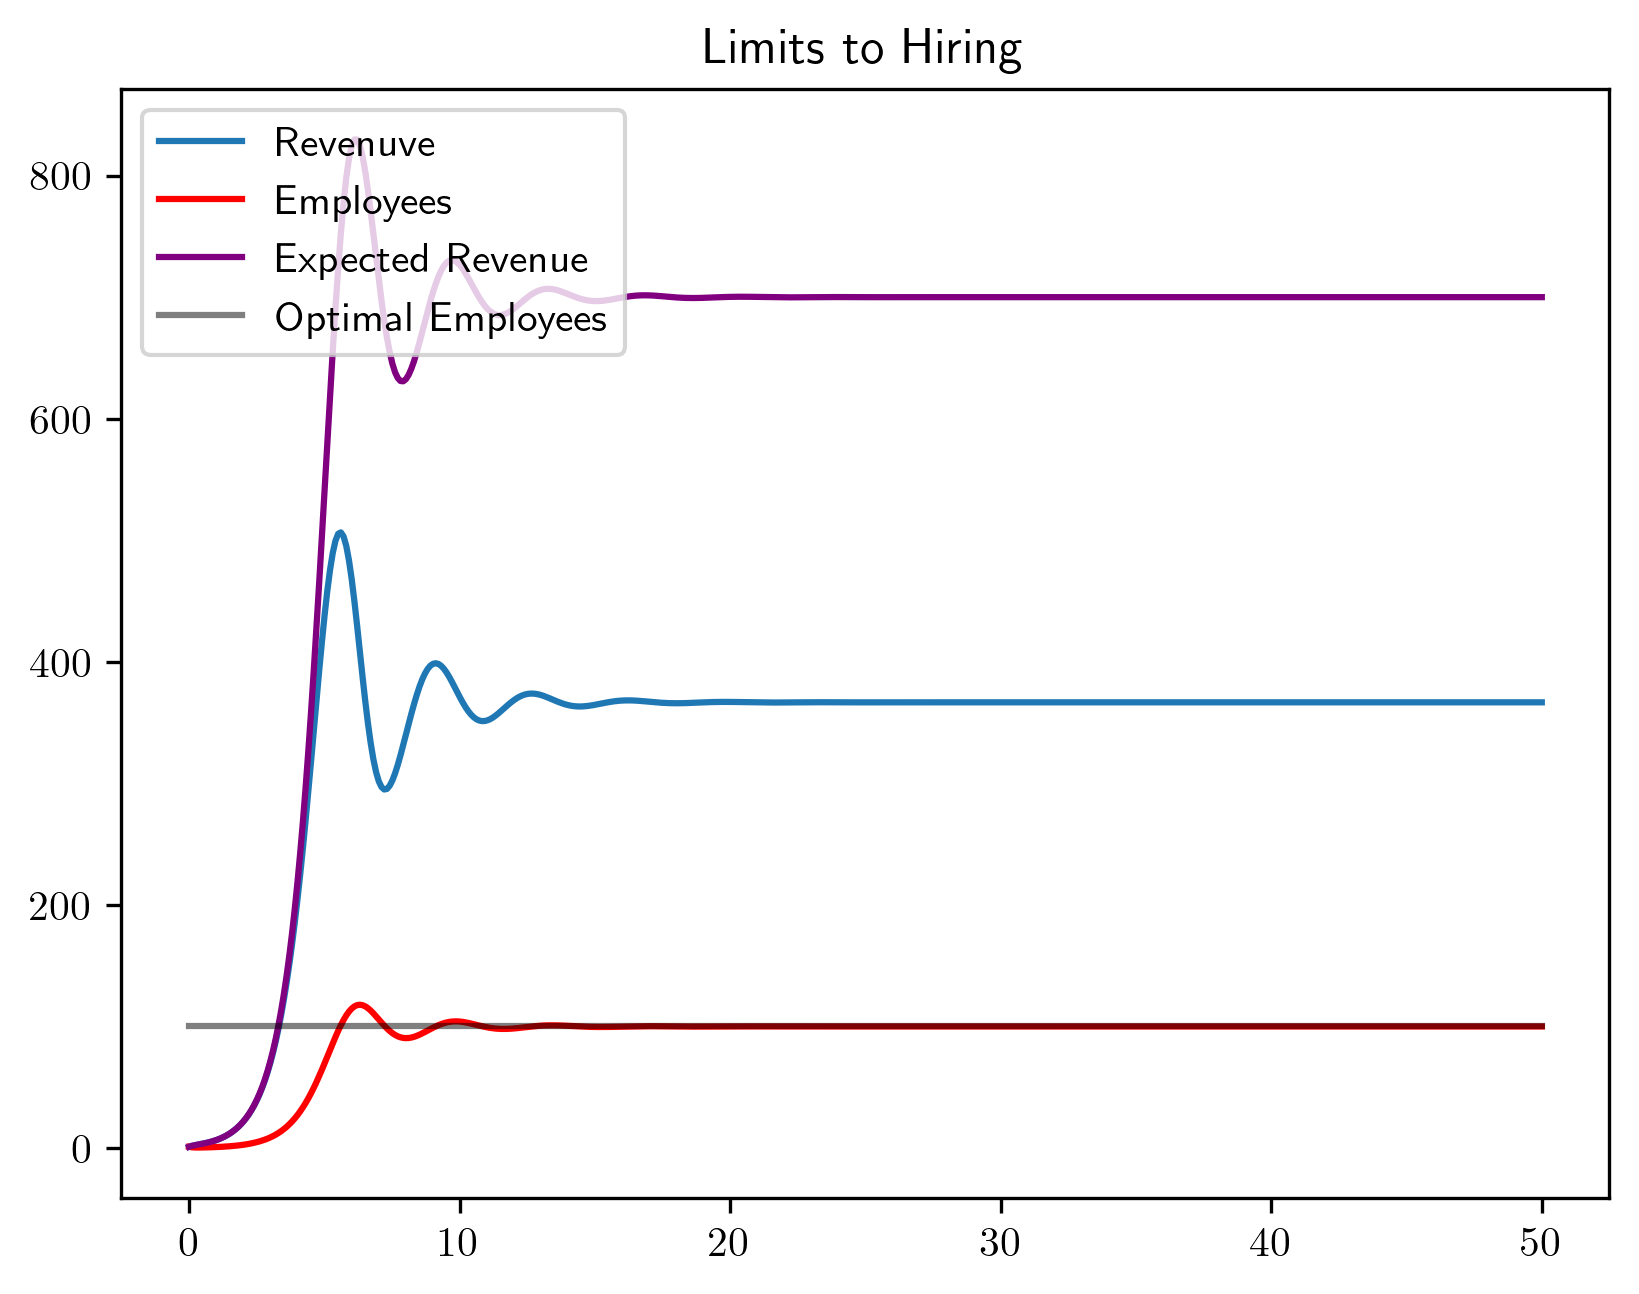

In [147]:
def hiring_on_expected_revenue_deriv(y, t, r, Estar, w, a):
    R, E, Rhat = y
    return [
        r * E * (1 - E / Estar),
        Rhat - w * E,
        r * E + a * (R - Rhat)
    ]

T = 50
t = np.linspace(0, T, T * 10)
r = 10
Estar = 100
w = 7
a = 3
ps = (r, Estar, w, a)
y0 = [1, 1, 1]

X = sp.integrate.odeint(hiring_on_expected_revenue_deriv, y0, t, ps)
plt.plot(t, X[:, 0], label="Revenuve")
plt.plot(t, X[:, 1], c="r", label="Employees")
plt.plot(t, X[:, 2], c="purple", label="Expected Revenue")
plt.plot(t, Estar * np.ones_like(t), c="k", alpha=0.5, label="Optimal Employees")

plt.legend()
plt.title("Limits to Hiring 2")
plt.show()

This model achives the overshoot and correction that we want but it would be better if revenue was a function of employees rather than a growth rate based on them. When it is a growth rate based on employees the growth in employees messes with the revenue. This might be a good model, for something else but it isn't what I had in mind.

Then we will write revenue as a function of employees. We expect revenue to increase with the number of employees but the rate that it increases slows down. We'll use a scaled and shifted sigmoid

$$R(E) = \frac{R_\text{max}}{1 - \frac{R_\text{max} - R_0}{R_0}e^{-E / r}}$$ 

because this is the solution to the logistic equation.

Now we can write

$$
\frac{dE}{dt} = \hat{R} - wE
$$

$$
\frac{d\hat{R}}{dt} = rE + a(R(E) - \hat{R})
$$

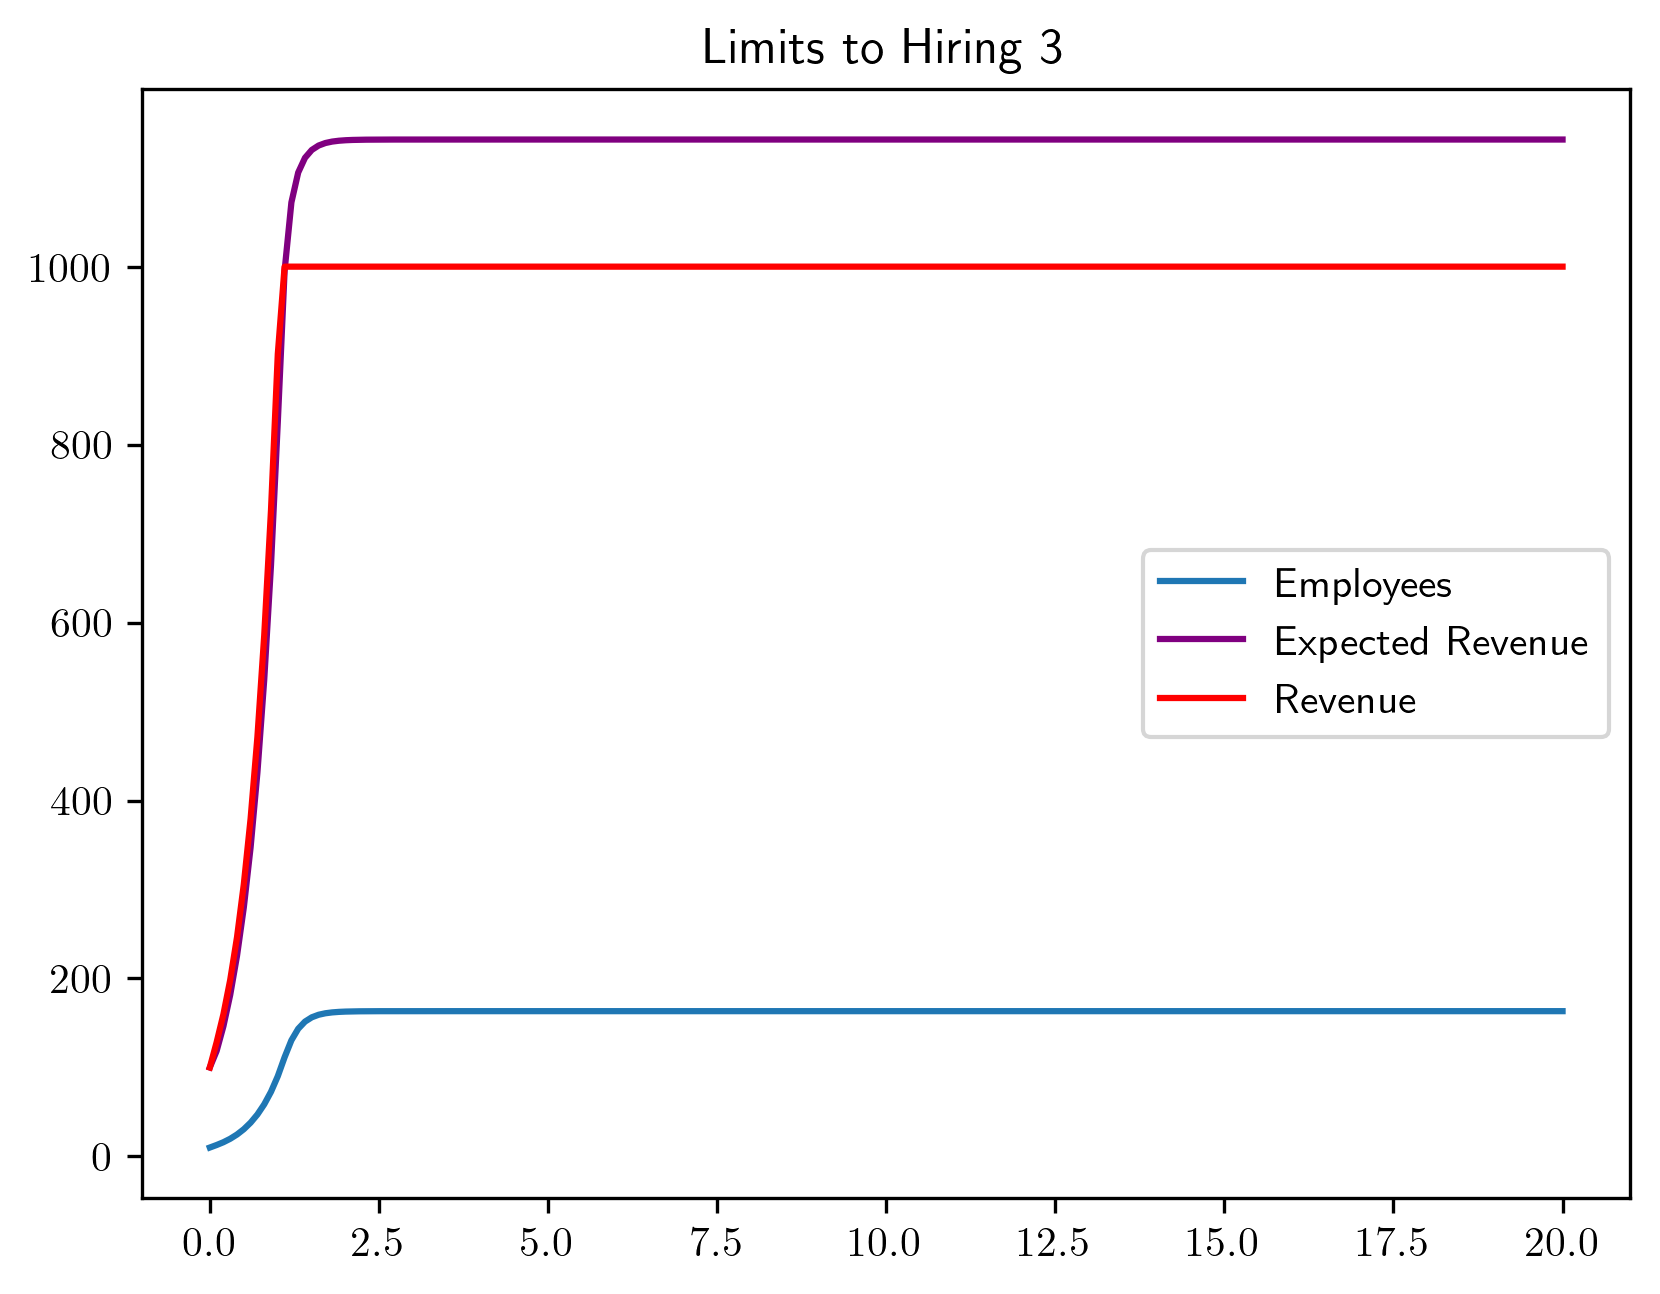

In [212]:
Rmax = 1000
R0 = 1
# R = lambda E: Rmax / (1 + (Rmax - R0) / R0 * np.exp(-1 * (E) / r))
R = np.vectorize(lambda E: min(r * E, Rmax))
Rhat = lambda E: np.exp(E / r)

def hiring_on_expected_revenue_deriv2(y, t, r, w, a):
    E, Rhat = y
    return [
        Rhat - w * E,
        r * E + a * (R(E) - Rhat)
    ]

T = 20
t = np.linspace(0, T, T * 10)
r = 10
w = 7
a = r / w + 10
ps = (r, w, a)
y0 = [10, 100]

X = sp.integrate.odeint(hiring_on_expected_revenue_deriv2, y0, t, ps)
plt.plot(t, X[:, 0], label="Employees")
plt.plot(t, X[:, 1], c="purple", label="Expected Revenue")
plt.plot(t, R(X[:, 0]), c="r", label="Revenue")

plt.legend()
plt.title("Limits to Hiring 3")
plt.show()

In [182]:
i = 100
print(X[i, :])
hiring_on_expected_revenue_deriv2(X[i, :], 0, *ps)

[ 2.26677804 15.90644334]


[0.03899704429984041, 0.27063705193535625]

#### Trying a third time: Limits to Revenue

This did not capture what I wanted it to. Eventually I put in a simpler function for revenue:

$$ R(E) = max(rE, R_\text{max}) $$

Where $r$ is the rate of return per employee.

Let's do this a little differently and use a profit function.

$P(E) = R(E) - wE$ 

Here, $w$ is wages. Revenue is a function that increases with the number of employees but eventually slows down. Consider the function
$$
f(x) = \frac{x}{x + a}
$$

It has some good properties: $f(0) = 0$ and $\displaystyle \lim_{x \rightarrow \infty} f(x) = 1$. The distance from the limit is mediated by $a$. That is,
$$ |1 - f(x)| = |1 - \frac{x}{x + a}| = | \frac{x + a}{x + a} - \frac{x}{x + a}| = | \frac{a}{x + a} | $$
$$ | 1 - f(x)| = |\frac{a}{x+a}| $$

Therefore, when $x$ becomes more positive, the distance to the limit is $\mathcal{O}(\frac{a}{x})$.

This means that increasing $a$ decreases the speed that the function approaches the limit and decreasing $a$ increasrs the speed that it approaches one. By mulitplying this function by a desired limit, we can create a function with a limit where we want it and a rate of growth that we can tune.

Then, let's define revenue
$$R(E) = R_\text{max}\frac{E}{E + 1/r} = \frac{R_\text{max}}{rE + 1} rE$$

Then profit,
$$P(E) = R(E) - wE$$

Then initial expected profit:
$$\hat{P}_0(E) = rE - wE$$

The response when expectations are not met is to start believing obserations more. The larger distance between profit and expected profit, the more you doubt your initial expectation. However, you don't go back to believing your original belief once you see you are wrong. This means that a single variable function won't be able to describe this behavior.





$$\frac{dE}{dt} = h\hat{P}(E)$$

Employees grow at some constant hiring rate $h$ times expected profits.

Expected profits grows at the same rate as the initial expectation, but this rate is moderated by the relative sizes of expected profit and true profit. When the true profit is greater than the expected, expected profits will decrease. It will not change when they are equal.
$$\frac{d\hat{P}}{dt} = \frac{d}{dt}\hat{P}_0(E) \, (1 - \frac{P(E)}{\hat{P}(E)})$$
$$\frac{d\hat{P}}{dt} = (r - w) \, (1 - \frac{P(E)}{\hat{P}(E)})$$


In [ ]:
R = lambda E: Rmax * (r*E) 